## AI Edge Contest (Segmentation Division) 

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import os

print (os.listdir('/content/gdrive/My Drive/SIGNATE/AIEdge/'))
print (os.listdir('/content/gdrive/My Drive/SIGNATE/AIEdge/data/'))

['v1.ipynb', 'data', 'Tutorial.ipynb']
['seg_train_images', 'mini_train_images', 'mini_train_annotations', 'mini_val_images', 'mini_val_annotations', 'seg_test_images']


In [4]:
data_path = '/content/gdrive/My Drive/SIGNATE/AIEdge/data/'

train_img_files = os.listdir(data_path+'seg_train_images')
#train_annotation_files = os.listdir(data_path+'seg_train_annotations')
test_img_files = os.listdir(data_path+'seg_test_images')

print ('# of train image files: ', len(train_img_files))
#print ('# of annotation files: ', len(train_annotation_files))
print ('# of test image files: ', len(test_img_files))

# of train image files:  2243
# of test image files:  649


Library

In [0]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from PIL import Image

from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Dropout, Conv2D, Conv2DTranspose
from keras.layers import concatenate
from keras.callbacks import EarlyStopping

import json

Data

In [0]:
_train_images_path_mini = '/content/gdrive/My Drive/SIGNATE/AIEdge/data/mini_train_images/'
_train_annotations_path_mini = '/content/gdrive/My Drive/SIGNATE/AIEdge/data/mini_train_annotations/'

# of image files mini:  1000
# of annotation files mini:  1000

file name:  train_0494

size:  (1216, 1936, 3)



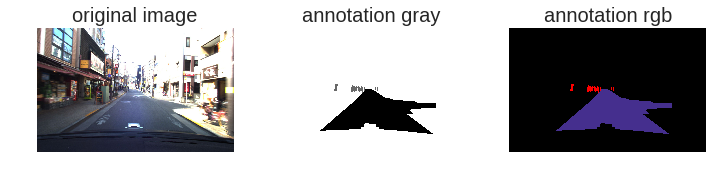


% of 0:  88.99241178229666
% of 1:  0.0
% of 2:  0.3472552604393215
% of 3:  10.660332957264028
% of 4:  0.0


In [7]:
train_images_files_mini = os.listdir(_train_images_path_mini)
train_annotation_files_mini = os.listdir(_train_annotations_path_mini)

print ('# of image files mini: ', len(train_images_files_mini))
print ('# of annotation files mini: ', len(train_annotation_files_mini))
print ()

idx = np.random.randint(len(train_annotation_files_mini))
name = train_annotation_files_mini[idx].split('.')[0]
print('file name: ', name)
print ()

original_image = Image.open(os.path.join(_train_images_path_mini, name+'.jpg'))
original_image_array= np.array(original_image)
print ('size: ', original_image_array.shape)
print ()

annotation = Image.open(os.path.join(_train_annotations_path_mini, name+'.png'))
annotation_array = np.array(annotation)

y_m = np.zeros([annotation_array.shape[0], annotation_array.shape[1], 3]).astype(int)

for i in range(annotation_array.shape[0]):
  for j in range(annotation_array.shape[1]):
    if annotation_array[i, j] == 0:
      y_m[i, j, :] = [0, 0, 0]
    elif annotation_array[i, j] == 1:
      y_m[i, j, :] = [0, 0, 255]
    elif annotation_array[i, j] == 2:
      y_m[i, j, :] = [255, 0, 0]
    elif annotation_array[i, j] == 3:
      y_m[i, j, :] = [69, 47, 142]
    elif annotation_array[i, j] == 4:
      y_m[i, j, :] = [255, 255, 0]
    else:
      pass
    

#annotation_p = annotation.convert('P')
#palette = annotation_p.getpalette()
#annotation_p_array = np.array(annotation_p)
#print ('palette shape: ', np.array(palette).reshape(-1, 3).shape)
#print ()

#annotation_rgb = annotation.convert('RGB')
#annotation_rgb_array = np.array(annotation_rgb)

fig, (axL, axM, axR) = plt.subplots(ncols=3, figsize=(12, 7))
axL.imshow(original_image_array)
axL.set_title('original image', fontsize=20)
axL.set_axis_off()

axM.imshow(annotation_array)
axM.set_title('annotation gray', fontsize=20)
axM.set_axis_off()

axR.imshow(y_m)
axR.set_title('annotation rgb', fontsize=20)
axR.set_axis_off()

plt.show()
print ()

total = annotation_array.shape[0] * annotation_array.shape[1] 
print ('% of 0: ', np.sum((annotation_array==0).astype(int)) / total * 100)
print ('% of 1: ', np.sum((annotation_array==1).astype(int)) / total * 100)
print ('% of 2: ', np.sum((annotation_array==2).astype(int)) / total * 100)
print ('% of 3: ', np.sum((annotation_array==3).astype(int)) / total * 100)
print ('% of 4: ', np.sum((annotation_array==4).astype(int)) / total * 100)

Generator

In [0]:
path_img_train = '/content/gdrive/My Drive/SIGNATE/AIEdge/data/mini_train_images/'
path_img_test = '/content/gdrive/My Drive/SIGNATE/AIEdge/data/mini_val_images/'

path_class_train = '/content/gdrive/My Drive/SIGNATE/AIEdge/data/mini_train_annotations/'
path_class_test = '/content/gdrive/My Drive/SIGNATE/AIEdge/data/mini_val_annotations/'

In [9]:
files_train = os.listdir(path_img_train)
list_train = np.array([s[:-4] for s in files_train]) 

files_test = os.listdir(path_img_test)
list_test = np.array([s[:-4] for s in files_test]) 

print ('size of train:', list_train.shape)
print (list_train[:5])
print ()
print ('size of valid:', list_test.shape)
print (list_test[:5])

size of train: (1000,)
['train_0000' 'train_0003' 'train_0004' 'train_0002' 'train_0005']

size of valid: (300,)
['train_1000' 'train_1002' 'train_1001' 'train_1005' 'train_1006']


In [0]:
def batch_iter(data, n_classes, img_size, batch_size, path_img, path_class, shuffle=True):
  num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1

  def data_generator():
    data_size = len(data)
    while True:
      # Shuffle the data at each epoch
      if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
      else:
        shuffled_data = data
      
      for batch_num in range(num_batches_per_epoch):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        batch_list = shuffled_data[start_index: end_index] 
        
        x = []
        y = []
        
        for file_name in batch_list:
          img_pil = Image.open(path_img+file_name+'.jpg').resize((img_size, img_size))
          img_np = np.array(img_pil)
          x.append(img_np)
          
          class_pil = Image.open(path_class+file_name+'.png').resize((img_size, img_size))
          class_np = np.array(class_pil)
          y.append(class_np)
        
        x = np.array(x) / 255.
        y = np.array(y)
        #y_m = np.where(y==255, n_classes-1, y)
        y_oh = np.identity(n_classes)[y]
        
        yield x, y_oh
      
  return num_batches_per_epoch, data_generator()

In [11]:
n_classes = 5
img_size = 256
batch_size = 32

train_steps, train_batches = batch_iter(list_train, n_classes, img_size, batch_size, 
                                        path_img_train, path_class_train)
valid_steps, valid_batches = batch_iter(list_test, n_classes, img_size, batch_size, 
                                        path_img_test, path_class_test)

print (train_steps)
print (train_batches)
print (valid_steps)
print (valid_batches)

32
<generator object batch_iter.<locals>.data_generator at 0x7f459614c990>
10
<generator object batch_iter.<locals>.data_generator at 0x7f4555d19ca8>


In [0]:
#x, y = next(train_batches)

In [0]:
#print ('shape of x: ', x.shape)
#print ('shape of y: ', y.shape)
#print ()
#print (x[0, 120, 100:105])
#print (y[0, 120, 100:105])

Model

In [12]:
img_width = img_size
img_height = img_size

input_tensor = Input(shape=(img_width, img_height, 3))
    
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
#vgg_model.summary()

In [0]:
vgg_top = vgg_model.get_layer('block5_conv2').output

block1_conv2 = vgg_model.get_layer('block1_conv2').output
block2_conv2 = vgg_model.get_layer('block2_conv2').output
block3_conv3 = vgg_model.get_layer('block3_conv3').output
block4_conv3 = vgg_model.get_layer('block4_conv3').output

In [0]:
start_neurons = 64

# 8 -> 16
deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding='same')(vgg_top)
uconv4 = concatenate([deconv4, block4_conv3])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)
#uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)

# 16 -> 32
deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, block3_conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

# 32 -> 64
deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, block2_conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

# 64 -> 128
deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, block1_conv2])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

out = Conv2D(n_classes, (1,1), padding="same", activation="softmax")(uconv1)

model = Model(inputs=input_tensor, outputs=out)

#for layer in model.layers[:17]:
#    layer.trainable = False
    
for layer in vgg_model.layers:
    layer.trainable = False    

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
early_stopping = EarlyStopping(monitor='val_acc', patience=3, mode='max', 
                              verbose=1)

In [57]:
epochs = 3
history = model.fit_generator(train_batches, train_steps, epochs=epochs,
                              validation_data=valid_batches, 
                              validation_steps=valid_steps, 
                              callbacks=[early_stopping],
                              verbose=1)

Epoch 1/3
32/32 [==============================] - 102s 3s/step - loss: 0.1951 - acc: 0.9372 - val_loss: 0.1767 - val_acc: 0.9388
Epoch 2/3
32/32 [==============================] - 93s 3s/step - loss: 0.1840 - acc: 0.9394 - val_loss: 0.1870 - val_acc: 0.9378
Epoch 3/3
32/32 [==============================] - 93s 3s/step - loss: 0.1700 - acc: 0.9437 - val_loss: 0.1777 - val_acc: 0.9382


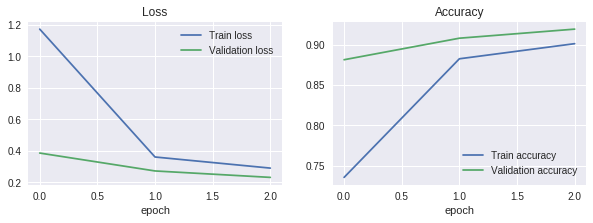

In [0]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10, 3))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_title('Loss')
ax_loss.set_xlabel('epoch')
ax_loss.legend(loc='best')

ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('epoch')
ax_acc.legend(loc='best')
plt.show()

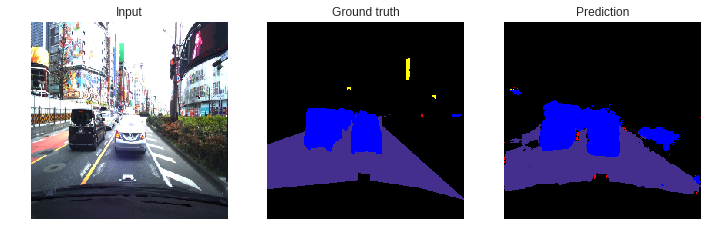


# of common:  61321
% of common:  93.56842041015625
% of 0 (ground truth):  74.89166259765625
% of 3 (ground truth):  17.70477294921875


In [59]:
# training data
idx = np.random.randint(len(list_train))
file_name = list_train[idx]
img_pil = Image.open(path_img_train+file_name+'.jpg').resize((img_size, img_size))
img_np = np.array(img_pil)
class_pil = Image.open(path_class_train+file_name+'.png').resize((img_size, img_size))
class_np = np.array(class_pil)

# test data
#idx = np.random.randint(len(list_test))
#file_name = list_test[idx]
#img_pil = Image.open(path_img_test+file_name+'.jpg').resize((img_size, img_size))
#img_np = np.array(img_pil)
#class_pil = Image.open(path_class_test+file_name+'.png').resize((img_size, img_size))
#class_np = np.array(class_pil)

x = np.expand_dims(img_np, axis=0)
y = np.array(class_pil)
y_pred = np.squeeze(np.argmax(model.predict(x), axis=-1))

y_m = np.zeros([y.shape[0], y.shape[1], 3]).astype(int)
y_pred_m = np.zeros([y.shape[0], y.shape[1], 3]).astype(int)

for i in range(y.shape[0]):
  for j in range(y.shape[1]):
    if y[i, j] == 0:
      y_m[i, j, :] = [0, 0, 0]
    elif y[i, j] == 1:
      y_m[i, j, :] = [0, 0, 255]
    elif y[i, j] == 2:
      y_m[i, j, :] = [255, 0, 0]
    elif y[i, j] == 3:
      y_m[i, j, :] = [69, 47, 142]
    elif y[i, j] == 4:
      y_m[i, j, :] = [255, 255, 0]
    else:
      pass

    if y_pred[i, j] == 0:
      y_pred_m[i, j, :] = [0, 0, 0]
    elif y_pred[i, j] == 1:
      y_pred_m[i, j, :] = [0, 0, 255]
    elif y_pred[i, j] == 2:
      y_pred_m[i, j, :] = [255, 0, 0]
    elif y_pred[i, j] == 3:
      y_pred_m[i, j, :] = [69, 47, 142]
    elif y_pred[i, j] == 4:
      y_pred_m[i, j, :] = [255, 255, 0]
    else:
      pass

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_np)
ax1.set_title('Input')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(y_m)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(y_pred_m)
ax3.set_title('Prediction')
ax3.set_axis_off()

plt.show()

print ()
print ('# of common: ', np.sum((y==y_pred).astype(int)))
print ('% of common: ', np.sum((y==y_pred).astype(int))/ img_size**2 * 100)
print ('% of 0 (ground truth): ', np.sum((y==0).astype(int))/ img_size**2 * 100)
print ('% of 3 (ground truth): ', np.sum((y==3).astype(int))/ img_size**2 * 100)

Make a json file

In [66]:
%%time

categories = [('car',[0,0,255]),('pedestrian',[255,0,0]),('lane',[69,47,142]),('signal',[255,255,0])]
predictions = {}
L = os.listdir(data_path+'seg_test_images/')

for l in tqdm(L):
  name = l.split('.')[0]+'.jpg'
  #print(name)
  predictions[name]={}

  img_pil = Image.open(data_path+'seg_test_images/'+name).resize((img_size, img_size))
  img_np = np.array(img_pil)

  x = np.expand_dims(img_np, axis=0)
  y_pred = np.squeeze(np.argmax(model.predict(x), axis=-1)).astype(np.uint8)
  y_pred_check = np.ones_like(y_pred) * 3   # for checking
  
  #label_pred = np.array(Image.fromarray(y_pred).resize((1936, 1216)))
  label_pred = np.array(Image.fromarray(y_pred_check).resize((1936, 1216)))

  for i,category in enumerate(categories):
    category_segments_pred = {}
    x_pred, y_pred = np.where(label_pred==(i+1))

    category_pix_pred = {}
    for i,j in zip(x_pred,y_pred):
      if i not in category_pix_pred:
        category_pix_pred[i]=[]
      category_pix_pred[i].append(j)

    for l in category_pix_pred:
      segments = []
      num_segments = 0
      for i,v in enumerate(sorted(category_pix_pred[l])):
        if i==0:
          start=v
          end=v
        else:
          if v==end+1:
            end = v
          else:
            segments.append([int(start),int(end)])
            start = v
            end = v
            num_segments+=1
      segments.append([int(start),int(end)])
      category_segments_pred[int(l)]=segments
    if len(category_pix_pred):
      predictions[name][category[0]]=category_segments_pred

100%|██████████| 649/649 [27:08<00:00,  2.52s/it]

CPU times: user 26min 48s, sys: 24.3 s, total: 27min 12s
Wall time: 27min 8s


In [0]:
with open(data_path+'predictions_3.json', 'w') as f:
  json.dump(predictions, f)

In [70]:
print (os.listdir(data_path))

['seg_train_images', 'mini_train_images', 'mini_train_annotations', 'mini_val_images', 'mini_val_annotations', 'seg_test_images', 'predictions_1.json', 'predictions_2.json', 'predictions_3.json']


In [73]:
with open(data_path+'predictions_3.json', 'r') as rf:
  json_data = json.load(rf)
  json_data_str = json.dumps(json_data)

{"tes


In [75]:
print (json_data_str[:50])  

{"test_000.jpg": {"lane": {"0": [[0, 1935]], "1": 


for checking

In [0]:
#categories = [('car',[0,0,255]),('pedestrian',[255,0,0]),('lane',[69,47,142]),('signal',[255,255,0])]
categories = [('0',[0,0,0]),('1',[0,0,255]),('2',[255,0,0]),('3',[69,47,142]),('4',[255,255,0])]

print (str(y[150, 150]==1))

y_m = np.zeros([y.shape[0], y.shape[1], 3])

for i in range(y.shape[0]):
  for j in range(y.shape[1]):
    if y[i, j] == 0:
      y_m[i, j, :] = [0, 0, 0]
    elif y[i, j] == 1:
      y_m[i, j, :] = [0, 0, 255]
    elif y[i, j] == 2:
      y_m[i, j, :] = [255, 0, 0]
    elif y[i, j] == 3:
      y_m[i, j, :] = [69, 47, 142]
    elif y[i, j] == 4:
      y_m[i, j, :] = [255, 255, 0]
    else:
      pass
    

print (y_m.shape)
print (y_m[150, 3:8, :])

True
(256, 256, 3)
[[255.   0.   0.]
 [255.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]


In [45]:
L = os.listdir(data_path+'seg_test_images/')

for l in tqdm(L[:1]):
  name = l.split('.')[0]+'.jpg'
  #print(name)
  predictions[name]={}

  img_pil = Image.open(data_path+'seg_test_images/'+name).resize((img_size, img_size))
  img_np = np.array(img_pil)

  x = np.expand_dims(img_np, axis=0)
  y_pred = np.squeeze(np.argmax(model.predict(x), axis=-1)).astype(np.uint8)      
  label_pred = np.array(Image.fromarray(y_pred).resize((1936, 1216)))
    

100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [46]:
categories = [('car',[0,0,255]),('pedestrian',[255,0,0]),('lane',[69,47,142]),('signal',[255,255,0])]
predictions = {}
L = os.listdir(data_path+'seg_test_images/')

for l in tqdm(L[:1]):
    name = l.split('.')[0]+'.jpg'
    #print(name)
    predictions[name]={}
    
    img_pil = Image.open(data_path+'seg_test_images/'+name).resize((img_size, img_size))
    img_np = np.array(img_pil)

    x = np.expand_dims(img_np, axis=0)
    y_pred = np.squeeze(np.argmax(model.predict(x), axis=-1)).astype(np.uint8)
    label_pred = np.array(Image.fromarray(y_pred).resize((1936, 1216)))
    
    for i,category in enumerate(categories):
        category_segments_pred = {}
        x_pred, y_pred = np.where(label_pred==(i+1))
        
        category_pix_pred = {}
        for i,j in zip(x_pred,y_pred):
            if i not in category_pix_pred:
                category_pix_pred[i]=[]
            category_pix_pred[i].append(j)
        
        for l in category_pix_pred:
            segments = []
            num_segments = 0
            for i,v in enumerate(sorted(category_pix_pred[l])):
                if i==0:
                    start=v
                    end=v
                else:
                    if v==end+1:
                        end = v
                    else:
                        segments.append([int(start),int(end)])
                        start = v
                        end = v
                        num_segments+=1
            segments.append([int(start),int(end)])
            category_segments_pred[int(l)]=segments
        if len(category_pix_pred):
            predictions[name][category[0]]=category_segments_pred


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


In [0]:
categories = [('car',[0,0,255]),('pedestrian',[255,0,0]),('lane',[69,47,142]),('signal',[255,255,0])]
predictions = {}
ground_truth = {}
L = os.listdir('mini_val_annotations')
for l in L:
    name = l.split('.')[0]+'.jpg'
    print(name)
    predictions[name]={}
    ground_truth[name]={}
    img = Image.open(os.path.join(_train_annotations_path,l))
    original_img = read_image(os.path.join('mini_val_images', name))
    original_img_resized = resize(original_img, (304, 484))
    label_pred = np.array(Image.fromarray(model.predict([original_img_resized])[0]).resize((1936, 1216)))
    for i,category in enumerate(categories):
        category_segments = {}
        category_segments_pred = {}
        x,y=np.where((np.array(img)==category[1]).sum(axis=2)==3)
        x_pred, y_pred = np.where(label_pred==(i+1))
        category_pix = {}
        category_pix_pred = {}
        for i,j in zip(x,y):
            if i not in category_pix:
                category_pix[i]=[]
            category_pix[i].append(j)

        for i,j in zip(x_pred,y_pred):
            if i not in category_pix_pred:
                category_pix_pred[i]=[]
            category_pix_pred[i].append(j)

        for l in category_pix:
            segments = []
            num_segments = 0
            for i,v in enumerate(sorted(category_pix[l])):
                if i==0:
                    start=v
                    end=v
                else:
                    if v==end+1:
                        end = v
                    else:
                        segments.append([int(start),int(end)])
                        start = v
                        end = v
                        num_segments+=1
            segments.append([int(start),int(end)])
            category_segments[int(l)]=segments
        if len(category_pix):
            ground_truth[name][category[0]]=category_segments

        for l in category_pix_pred:
            segments = []
            num_segments = 0
            for i,v in enumerate(sorted(category_pix_pred[l])):
                if i==0:
                    start=v
                    end=v
                else:
                    if v==end+1:
                        end = v
                    else:
                        segments.append([int(start),int(end)])
                        start = v
                        end = v
                        num_segments+=1
            segments.append([int(start),int(end)])
            category_segments_pred[int(l)]=segments
        if len(category_pix_pred):
            predictions[name][category[0]]=category_segments_pred

In [79]:
cost = {'TV':100, 'camera':200, 'radio':300}
js = json.dumps(cost)

print (js)
print (json.loads(js))


{"TV": 100, "camera": 200, "radio": 300}
{'TV': 100, 'camera': 200, 'radio': 300}
